# Functions

In [7]:
# set plot conf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

DAYS_BEFORE = 300


In [3]:
# import necessaries
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import tushare as ts
from datetime import datetime, timedelta
import time
from scipy import stats
pro = ts.pro_api()
pd.set_option('display.max_rows', 1000)



# ignore warning
import warnings
warnings.filterwarnings("ignore")

# def draw_pic(data, title_name):
#     plt.figure(figsize=(12,8))
#     plt.plot(data)
#     plt.title(title_name)
#     plt.show()


def get_option_info(key_words_list):
    temp = pro.opt_basic(
        exchange='SSE',
        call_put='C',
        fields=
        'ts_code,name,exercise_price, list_date,delist_date,maturity_date')
    for i in key_words_list:
        temp = temp[temp['name'].str.contains(i)]
    return temp


def get_opiton_code(key_words_list):
    return str(get_option_info(key_words_list)['ts_code'].values[0])


def get_date_info(option_info):
    begin_date = str(option_info['list_date'].values[0])
    end_date = str(option_info['delist_date'].values[0])
    before_begin_date = datetime.strftime(
        datetime.strptime(begin_date, '%Y%m%d') - timedelta(days=DAYS_BEFORE),
        '%Y%m%d')
    return begin_date, end_date, before_begin_date


def col_to_date_and_as_index(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df.index = df[col_name]


def get_option_trade_data(option_code):
    pro = ts.pro_api()
    option_trade = pro.opt_daily(ts_code=option_code)
    col_to_date_and_as_index(option_trade, 'trade_date')
    return option_trade.sort_index()


def get_underlying_asset_trade_data():
    pro = ts.pro_api()
    data = pro.fund_daily(
        ts_code='510050.SH', start_date=before_begin_date, end_date=end_date)
    col_to_date_and_as_index(data, 'trade_date')
    return data.sort_index()


def history_volatility(price_series, periods):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['std'] = price_series.rolling(window=periods).std(
        ddof=1) * np.sqrt(250) / np.sqrt(periods)
    return volatility['std']


def get_risk_free_rate_data():
    #pro = ts.pro_api()
    df = pro.shibor(
        start_date=begin_date, end_date=end_date, fields='date,3m,1y')
    df['ccr'] = np.log(1 + df['1y'] / 100)
    col_to_date_and_as_index(df, 'date')
    return df


def d1(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def d2(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q - sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def BlackScholes(type, S0, K, r, sigma, T, q=0):
    """
    S0  stock price
    K   strike price
    r   continuously compounded risk-free rate:
    sigma   volatility of the stock price per year
    T   time to maturity in trading years

    """
    if q!=0:
        print("q=",q)
    if type == "C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T,q)) - K * np.exp(
            -r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T,q))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(
            S0, K, r, sigma, T,q=0)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T,q=0))
   

In [4]:
def construct_BS_summary_table(key_words):
    """
    key_words - list: key words of option
    volatility - Pandas series: sigma of the underlying asset trade data
    """
    global begin_date, end_date, before_begin_date, option_code
    
    option_info = get_option_info(key_words)
    option_code = get_opiton_code(key_words)
    begin_date, end_date, before_begin_date = get_date_info(option_info)
    option_trade = get_option_trade_data(option_code)
    underlying_asset_trade = get_underlying_asset_trade_data()
    risk_free_rate = get_risk_free_rate_data()

    k = option_info['exercise_price'].values[0]
    summary = pd.DataFrame(index=option_trade.index)
    summary['s'] = underlying_asset_trade['close']
    summary['t'] = (
        datetime.strptime(option_info['maturity_date'].values[0], "%Y%m%d") -
        underlying_asset_trade['trade_date']).dt.days / 365.0
    summary['r'] = risk_free_rate['ccr']
    summary['sigma'] = history_volatility(underlying_asset_trade['close'], 90) 
    summary['bs_simulate'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'])
    summary['real_price'] = option_trade['close']
    summary = summary.dropna()
    return summary

In [5]:
def construct_BS_summary_table_div(key_words, div):
    """
    key_words - list: key words of option
    volatility - Pandas series: sigma of the underlying asset trade data
    """
    global begin_date, end_date, before_begin_date, option_code
    option_info = get_option_info(key_words)
    option_code = get_opiton_code(key_words)
    begin_date, end_date, before_begin_date = get_date_info(option_info)
    option_trade = get_option_trade_data(option_code)
    underlying_asset_trade = get_underlying_asset_trade_data()
    risk_free_rate = get_risk_free_rate_data()

    k = option_info['exercise_price'].values[0]
    summary = pd.DataFrame(index=option_trade.index)
    summary['s'] = underlying_asset_trade['close']
    summary['t'] = (
        datetime.strptime(option_info['maturity_date'].values[0], "%Y%m%d") -
        underlying_asset_trade['trade_date']).dt.days / 365.0
    summary['r'] = risk_free_rate['ccr']
    summary['sigma'] = history_volatility(underlying_asset_trade['close'], 90) 
    #
    summary['bs_simulate'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'], q=div)
    summary['real_price'] = option_trade['close']
    summary = summary.dropna()
    return summary

# 2017 test

KeyboardInterrupt: 

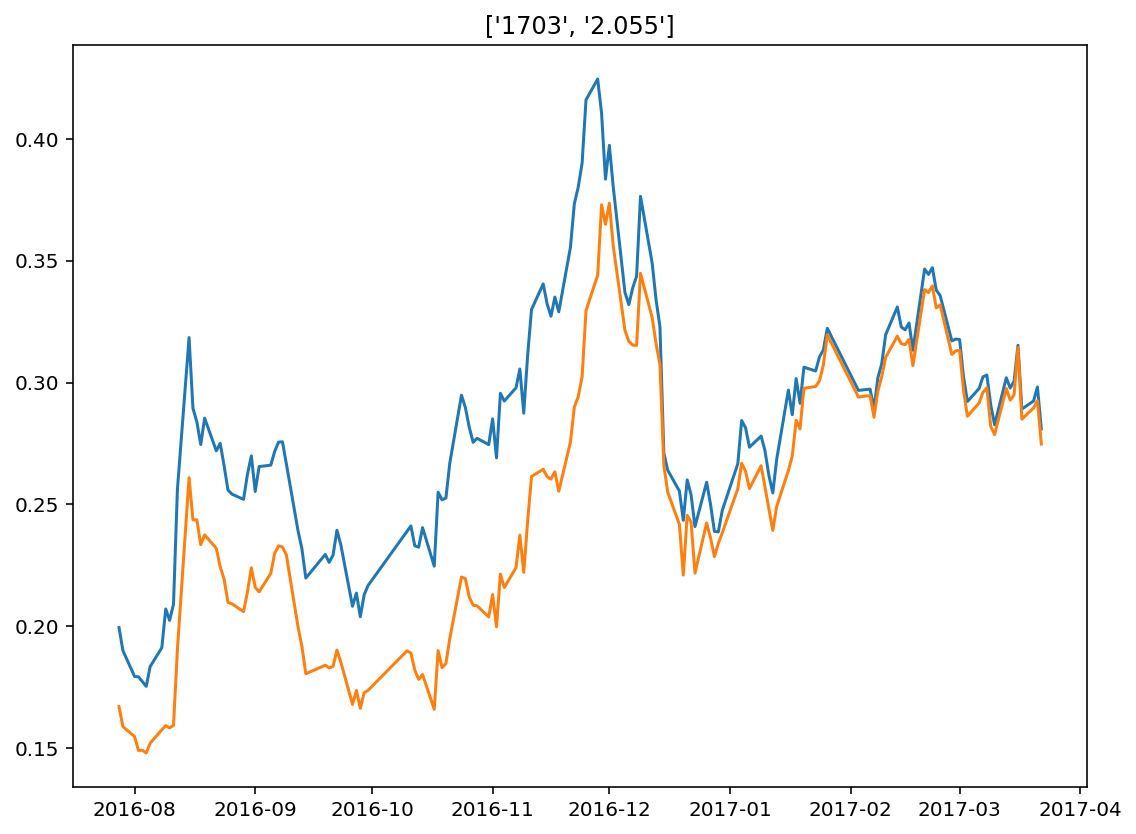

In [5]:
DAYS_BEFORE = 300

times = 1
plt.figure(figsize=(20,15))

for key_words in [['1703', '2.055'], ['1706', '2.153'],['1709', '2.25'],['1712', '2.16']]:
    plt.subplot(2,2,times)
    times += 1
    summary = construct_BS_summary_table(key_words)
    plt.plot(summary[['bs_simulate','real_price']]) # blue, orange
    plt.title(str(key_words))
    time.sleep(30)

In [ ]:
DAYS_BEFORE = 300

times = 1
plt.figure(figsize=(20,15))

for key_words in [['1703', '2.055'], ['1706', '2.153'],['1709', '2.25'],['1712', '2.16']]:
    plt.subplot(2,2,times)
    times += 1
    summary = construct_BS_summary_table(key_words)
    plt.plot(summary[['bs_simulate','real_price']]) # blue, orange
    plt.title(str(key_words))
    #time.sleep(30)

# 2018 test

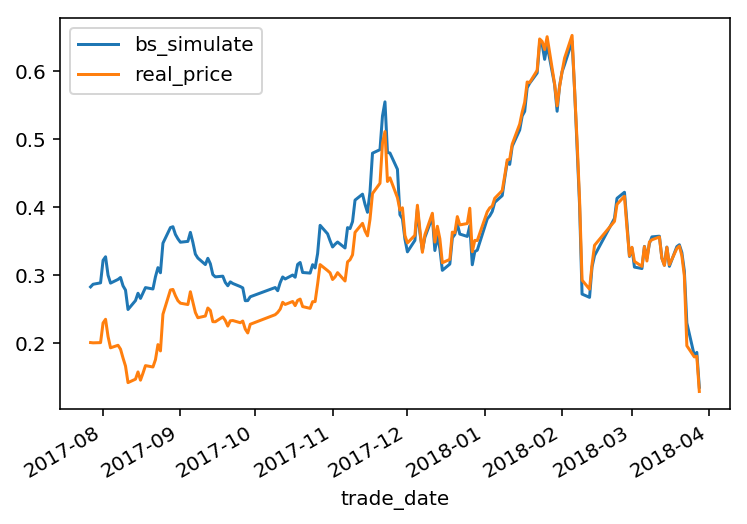

In [6]:
test = construct_BS_summary_table(['1803','2.553'])[['bs_simulate','real_price']].plot()
plt.legend()

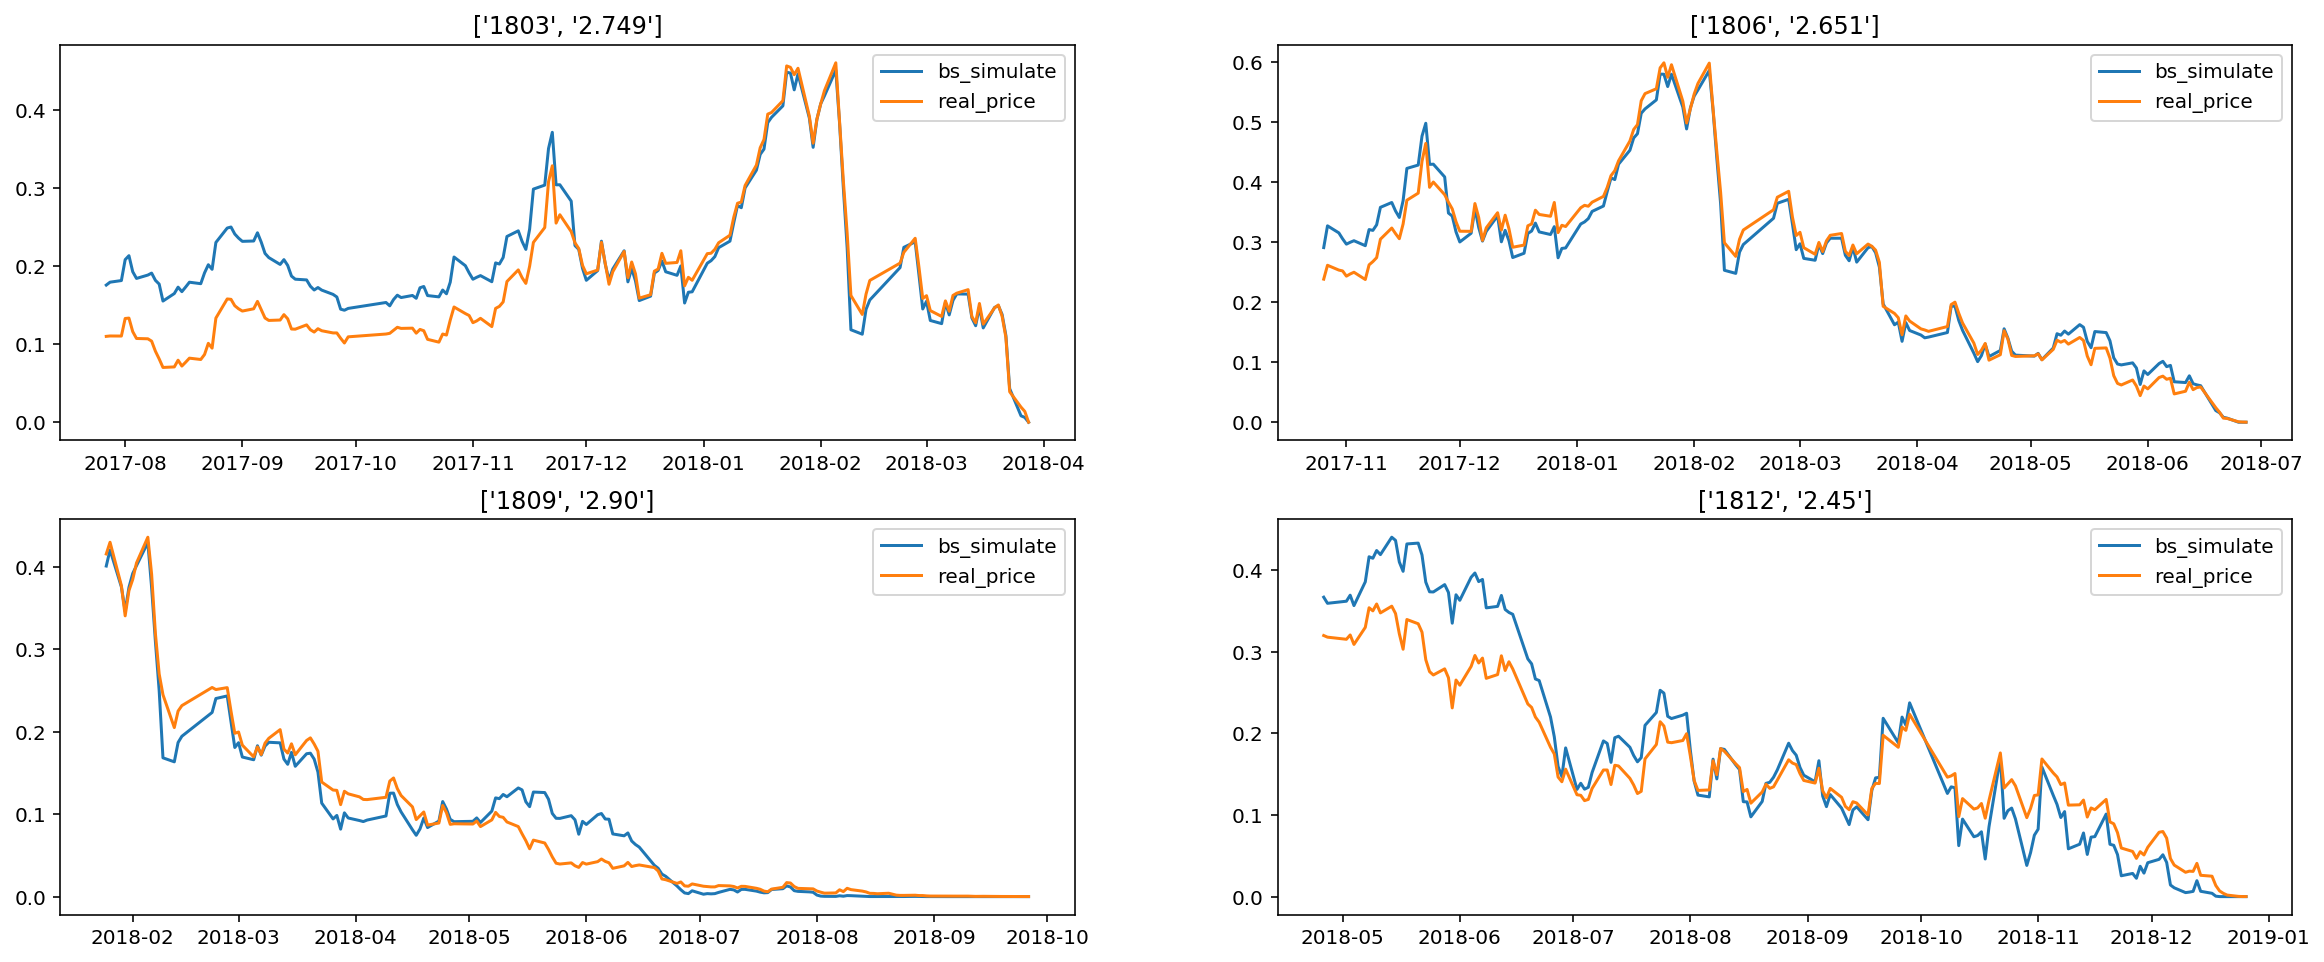

In [8]:

times = 1
plt.figure(figsize=(20,8))
for key_words in [['1803','2.749'], ['1806', '2.651'],['1809', '2.90'],['1812', '2.45']]:
    plt.subplot(2,2,times)
    times += 1
    
    summary = construct_BS_summary_table(key_words)
    plt.plot(summary['bs_simulate'], label = 'bs_simulate')
    plt.plot(summary['real_price'], label = 'real_price')
    plt.legend(loc = 'upper right')
    plt.title(str(key_words))
    time.sleep(30)

# others

In [ ]:
option_code

In [11]:
summary = construct_BS_summary_table(['1812','2.45'])
summary

,s,t,r,sigma,bs_simulate,real_price
trade_date,,,,,,
2018-04-26,2.655,0.668493,0.042897,0.244443,3.665264e-01,0.3196
2018-04-27,2.642,0.665753,0.042916,0.248113,3.590351e-01,0.3176
2018-05-02,2.646,0.652055,0.042830,0.251627,3.615956e-01,0.3150
2018-05-03,2.654,0.649315,0.042715,0.254750,3.689780e-01,0.3203
2018-05-04,2.634,0.646575,0.042648,0.258165,3.561996e-01,0.3087
2018-05-07,2.674,0.638356,0.042571,0.260505,3.853461e-01,0.3296
2018-05-08,2.714,0.635616,0.042561,0.262063,4.160068e-01,0.3536
2018-05-09,2.711,0.632877,0.042542,0.263636,4.141694e-01,0.3498
2018-05-10,2.723,0.630137,0.042542,0.264919,4.236367e-01,0.3582


# Implied Vol

![Newton's method](https://upload.wikimedia.org/wikipedia/commons/e/e0/NewtonIteration_Ani.gif)

## Version 2

In [12]:
def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in xrange(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # our root

        print i, sigma, diff

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

In [13]:
n = ss.norm.pdf
N = ss.norm.cdf


def bs_price(cp_flag, S, K, T, r, v, q=0.0):
    d1 = (np.log(S / K) + (r + v * v / 2.) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    if cp_flag == 'c':
        price = S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
    else:
        price = K * np.exp(-r * T) * N(-d2) - S * np.exp(-q * T) * N(-d1)
    return price


def bs_vega(cp_flag, S, K, T, r, v, q=0.0): # dPi/dSigma
    d1 = (np.log(S / K) + (r + v * v / 2.) * T) / (v * np.sqrt(T))
    return S * np.sqrt(T) * n(d1)

In [14]:
V_market = 17.5
K = 585
T = (datetime(2014,10,18) - datetime(2014,9,8)).days / 365.
S = 586.08
r = 0.0002
cp = 'c' # call option

implied_vol = find_vol(V_market, cp, S, K, T, r)

print 'Implied vol: %.2f%%' % (implied_vol * 100)

print 'Market price = %.2f' % V_market
print 'Model price = %.2f' % bs_price(cp, S, K, T, r, implied_vol)

0 0.5 -21.669539271534063
1 0.21879739316064523 0.03217154881230044
2 0.21921383628613422 1.9891615465894574e-08
Implied vol: 21.92%
Market price = 17.50
Model price = 17.50


In [15]:
def newton_vol_call(S, K, T, C, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0) - C #BS_price
    
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(ss.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while abs(xnew - xold) > tolerance:
    
        xold = xnew
        xnew = (xnew - fx - C) / vega # xn - 
        
        return abs(xnew)
    
newton_vol_call(25, 20, 1, 7, 0.05, 0.25)


0.3364790560328801

In [16]:
V_market = 17.5
K = 585
T = (datetime(2014,10,18) - datetime(2014,9,8)).days / 365.
S = 586.08
r = 0.0002
cp = 'c' # call option

newton_vol_call(S, K, T, 0, r, 0.5)

0.00022050562089437993

In [8]:
construct_BS_summary_table(['1812','2.45'])

,s,t,r,sigma,bs_simulate,real_price
trade_date,,,,,,
2018-04-26,2.655,0.668493,0.042897,0.244443,3.665264e-01,0.3196
2018-04-27,2.642,0.665753,0.042916,0.248113,3.590351e-01,0.3176
2018-05-02,2.646,0.652055,0.042830,0.251627,3.615956e-01,0.3150
2018-05-03,2.654,0.649315,0.042715,0.254750,3.689780e-01,0.3203
2018-05-04,2.634,0.646575,0.042648,0.258165,3.561996e-01,0.3087
2018-05-07,2.674,0.638356,0.042571,0.260505,3.853461e-01,0.3296
2018-05-08,2.714,0.635616,0.042561,0.262063,4.160068e-01,0.3536
2018-05-09,2.711,0.632877,0.042542,0.263636,4.141694e-01,0.3498
2018-05-10,2.723,0.630137,0.042542,0.264919,4.236367e-01,0.3582


# test

In [10]:
before_begin_date, begin_date, end_date

('20170630', '20180426', '20181226')